In [1]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

eradiate.plot.set_style()

In the following we calculate the radiance at a particular wavelength and select the mode "mono_polarized" which fully takes into account polarization. For simulations neglecting polarization select "mono".

List all available modes with ```eradiate.modes()```.

In [2]:
eradiate.set_mode("mono_polarized")

### Definition of a standard atmosphere

Standard atmospheres (e.g. tropical, midlatitude summer, midlatitude winter, subarctic summer, subarctic winter, US standard atmosphere 1976) are included in the joseki package and can be included as follows: 

In [3]:
usstd = ertsc.atmosphere.MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
)

### Definition of aerosols

Define a standard aerosol layer from 0 to 2 km using the desert aerosol type as defined by Govaerts 2021. The optical thickness is 0.5. 

In [4]:
particle_layer = ertsc.atmosphere.ParticleLayer(
    tau_ref=0.5,
    bottom=0 * ureg.m,
    top=2 * ureg.km,
    distribution="uniform",
    w_ref=550 * ureg.nm,
    dataset="govaerts_2021-desert-extrapolated",
)

### Merge molecules and particle layer in atmosphere structure

In [5]:
atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere=usstd, particle_layers=[particle_layer]
)

### Observation geometry

Specify the sensor: set up observation geometries for the almucantar plane and include the center wavelength of CE318.

In [6]:
wavelength = np.array([340, 380, 440, 500, 675, 870, 937, 1020, 1640]) * ureg.nm

# almucantar plane
vza = [np.array([30.0])]
vaa = np.arange(0.0, 181.0, 5.0) * ureg.deg

layout = eradiate.scenes.measure.GridLayout(
    zeniths=vza,
    azimuths=vaa,
)

origins = np.zeros_like(layout.directions) + 0.00001

measure = ertsc.measure.MultiRadiancemeterMeasure(
    id="almucantar",
    origins=origins,
    directions=layout.directions,
    srf={"type": "delta", "wavelengths": wavelength},
)

### Define an AtmosphereExperiment

All is put together in a eradiate "experiment". In addition the surface (here Lambertian) and the sun position need to be inlcuded.

In [7]:
def run_exp(spp, measure, atmosphere, integrator=None):
    """
    Run almucantar scan.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()

    exp = eradiate.experiments.AtmosphereExperiment(
        surface={
            "type": "lambertian",
            "reflectance": 0.05,
        },
        illumination={
            "type": "directional",
            "zenith": 30,
            "azimuth": 0,
            "irradiance": 1.0,
        },
        atmosphere=atmosphere,
        measures=measure,
        integrator=integrator,
    )

    exp.integrator.stokes = True
    exp.integrator.meridian_align = True

    return eradiate.run(exp, spp=spp)

### Run eradiate

In [23]:
result_eradiate = run_exp(spp=1000000, measure=measure, atmosphere=atmosphere)

0/9|          | 00:00, ETA=?

### Plot the results

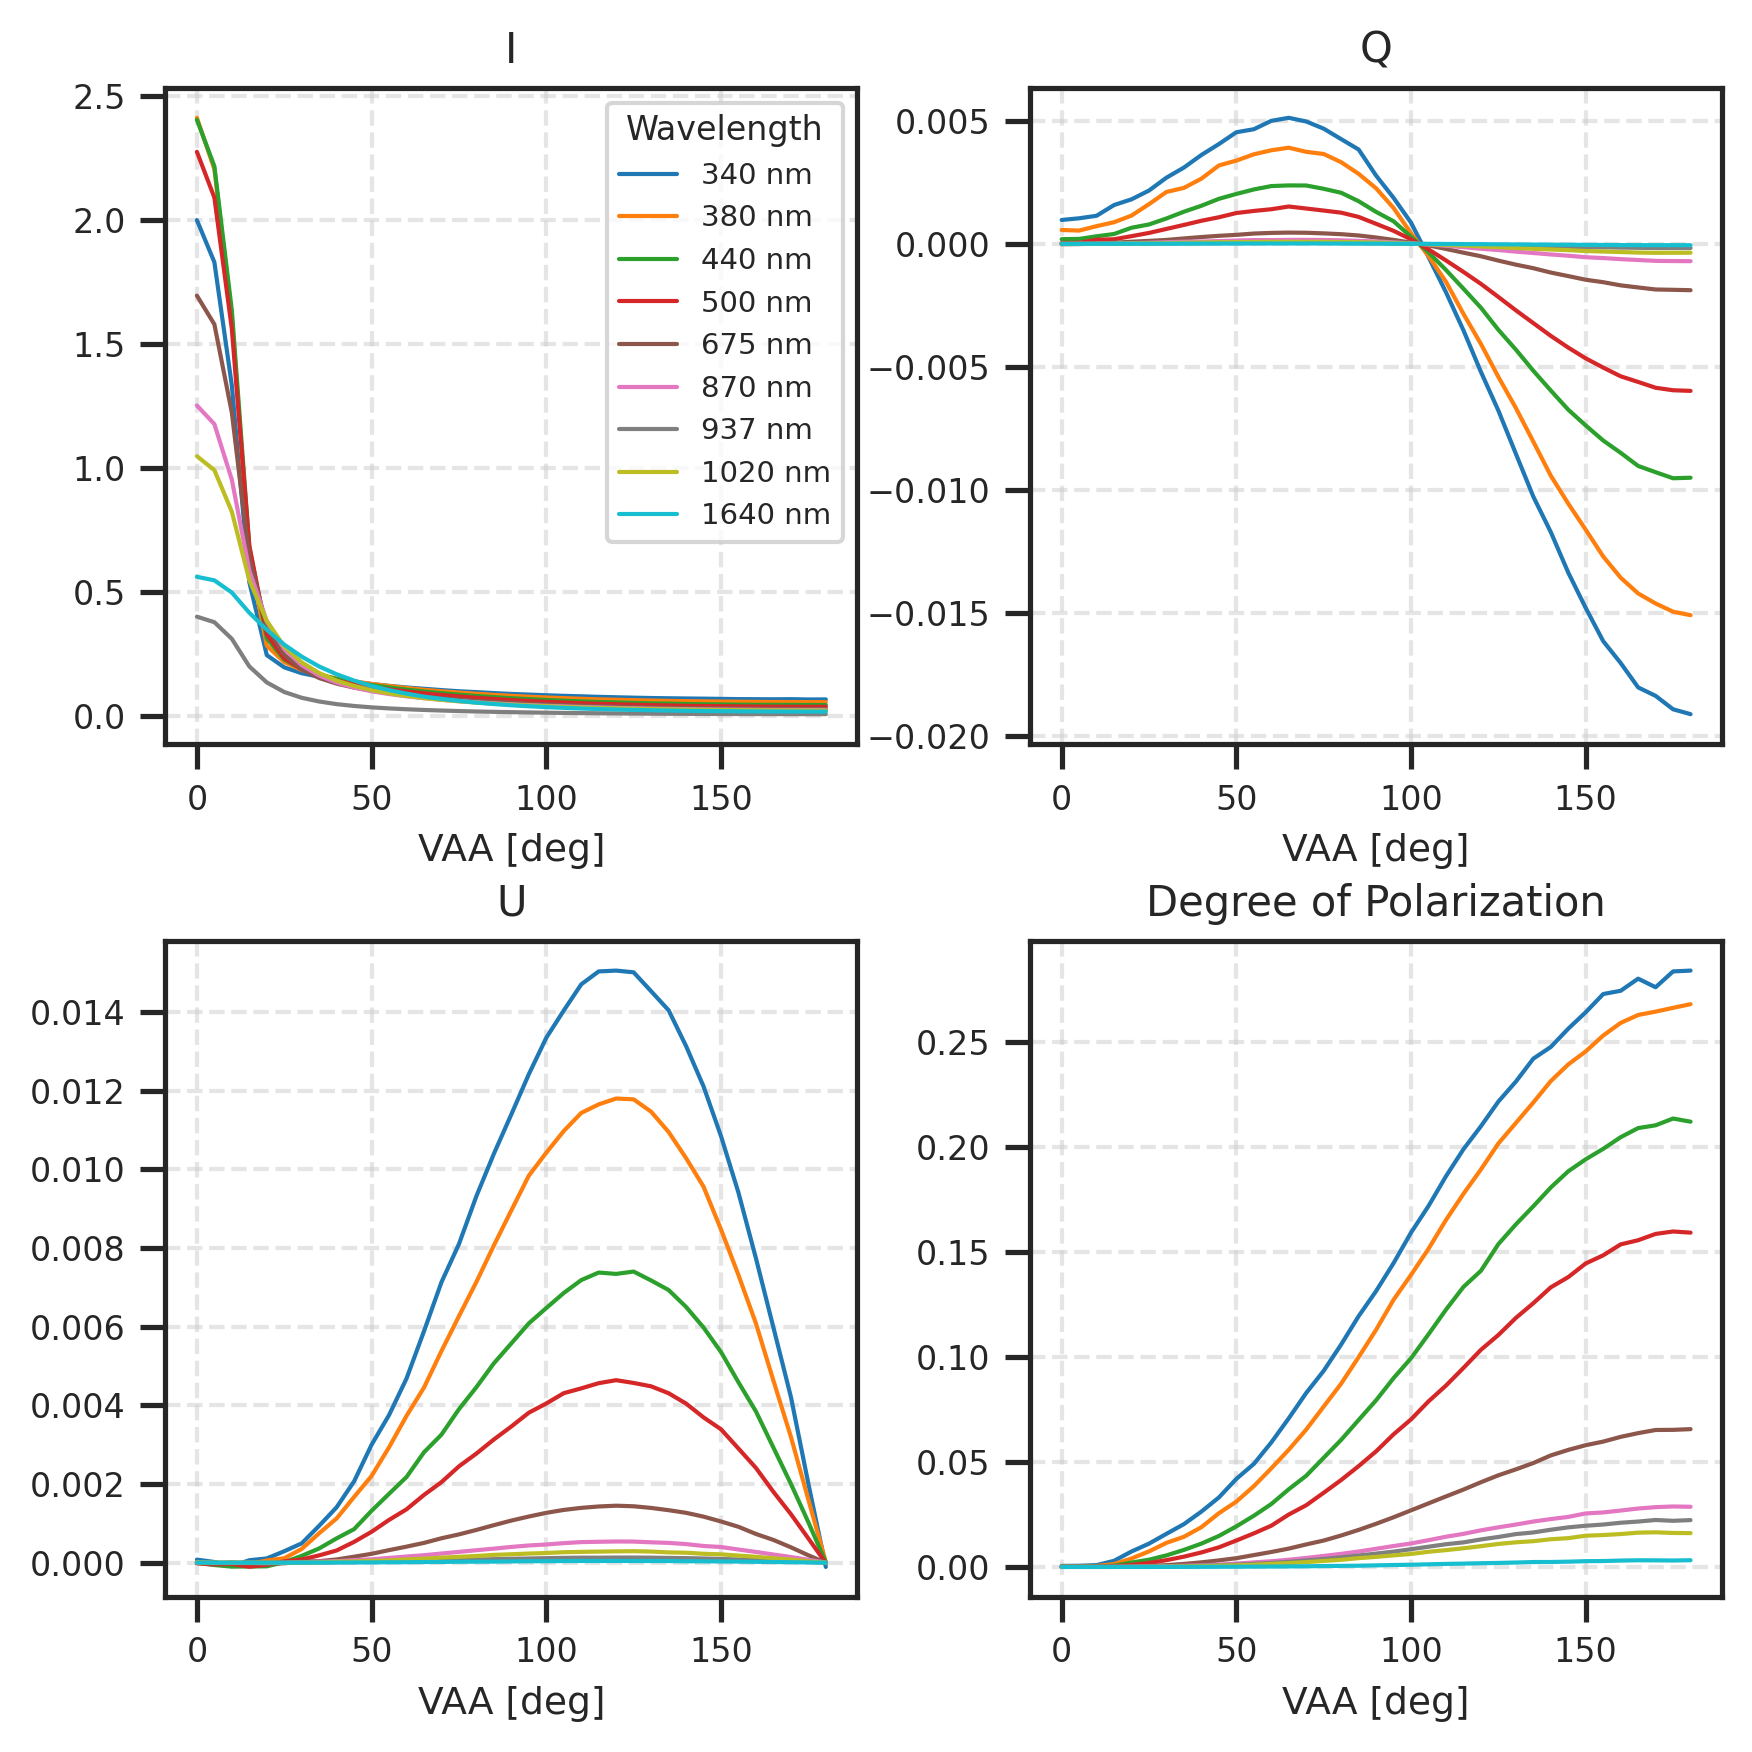

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=300)

labels = ["I", "Q", "U", "Degree of Polarization"]
ylabels = ["I", "Q", "U", "DoP"]
wavelengths = result_eradiate["w"].values
colors = cm.tab10(np.linspace(0, 1, len(wavelengths)))

# Flatten axs for easy indexing
axs = axs.flatten()

for idx in range(3):
    axs[idx].set_title(labels[idx], fontsize=10)
    axs[idx].set_xlabel("VAA [deg]", fontsize=9)
    # axs[idx].set_ylabel(ylabels[idx], fontsize=9)
    axs[idx].tick_params(axis="both", labelsize=8)
    axs[idx].grid(True, linestyle="--", alpha=0.5)
    for w_idx, wl in enumerate(wavelengths):
        axs[idx].plot(
            vaa.magnitude,
            result_eradiate["radiance"].data[w_idx, idx, 0, :, 0, 0],
            label=f"{int(wl)} nm" if idx == 0 else None,
            color=colors[w_idx],
            linewidth=1,
        )
    if idx == 0:
        axs[idx].legend(title="Wavelength", fontsize=7, title_fontsize=8, loc="best")

# Degree of polarization plot
axs[3].set_title(labels[3], fontsize=10)
axs[3].set_xlabel("VAA [deg]", fontsize=9)
# axs[3].set_ylabel(ylabels[3], fontsize=9)
axs[3].tick_params(axis="both", labelsize=8)
axs[3].grid(True, linestyle="--", alpha=0.5)
for w_idx, wl in enumerate(wavelengths):
    I = result_eradiate["radiance"].data[w_idx, 0, 0, :, 0, 0]
    Q = result_eradiate["radiance"].data[w_idx, 1, 0, :, 0, 0]
    U = result_eradiate["radiance"].data[w_idx, 2, 0, :, 0, 0]
    V = result_eradiate["radiance"].data[w_idx, 3, 0, :, 0, 0]
    dop = np.sqrt(Q**2 + U**2 + V**2) / np.abs(I)
    axs[3].plot(
        vaa.magnitude, dop, label=f"{int(wl)} nm", color=colors[w_idx], linewidth=1
    )

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.25)
plt.savefig("sunphotometer_almucantar.pdf", bbox_inches="tight", dpi=300)
plt.show()